# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [5]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [6]:
df.sample(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
131022,329607380,126983093,Hispanic,Female,[80-90),?,1,1,7,5,?,?,584,276|276,0,0,0,26,9,7,0,47918-902,None,None,No,>30
28159,74031090,111340854,Caucasian,Female,[80-90),?,1,1,7,4,?,?,996,428|599,0,4,0,52,8,12,0,0781-5422,None,None,Ch,>30
60506,136251780,93358053,Caucasian,Female,[80-90),?,1,3,7,9,SP,Emergency/Trauma,577,410|428,0,0,0,25,9,11,1,68071-1701,None,None,Ch,>30


## Determine Level of Dataset (Line or Encounter)

In [7]:
print("Total number of rows:", len(df))
print("Total unique encounters:", df.encounter_id.nunique())
print("Total number of patients:", df.patient_nbr.nunique())

Total number of rows: 143424
Total unique encounters: 101766
Total number of patients: 71518


**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response: 

The dataset is at line level as there are more records than the number of encounters. We also see that there are more encounters for each patient.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


In [8]:
null_df = df.copy()
null_df = null_df.replace('?', np.nan).replace('None', np.nan)

In [9]:
null_df.isnull().mean().sort_values(ascending=False)

weight                      0.970005
max_glu_serum               0.951089
A1Cresult                   0.820295
medical_specialty           0.484319
payer_code                  0.377831
ndc_code                    0.163585
race                        0.023071
primary_diagnosis_code      0.000230
patient_nbr                 0.000000
gender                      0.000000
age                         0.000000
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
readmitted                  0.000000
change                      0.000000
other_diagnosis_codes       0.000000
number_outpatient           0.000000
number_inpatient            0.000000
number_emergency            0.000000
num_lab_procedures          0.000000
number_diagnoses            0.000000
num_medications             0.000000
num_procedures              0.000000
encounter_id                0.000000
dtype: float64

###### Field(s) with high amount of missing/zero values: 

* weight                      
* max_glu_serum               
* A1Cresult 
* medical_specialty
* payer_code

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

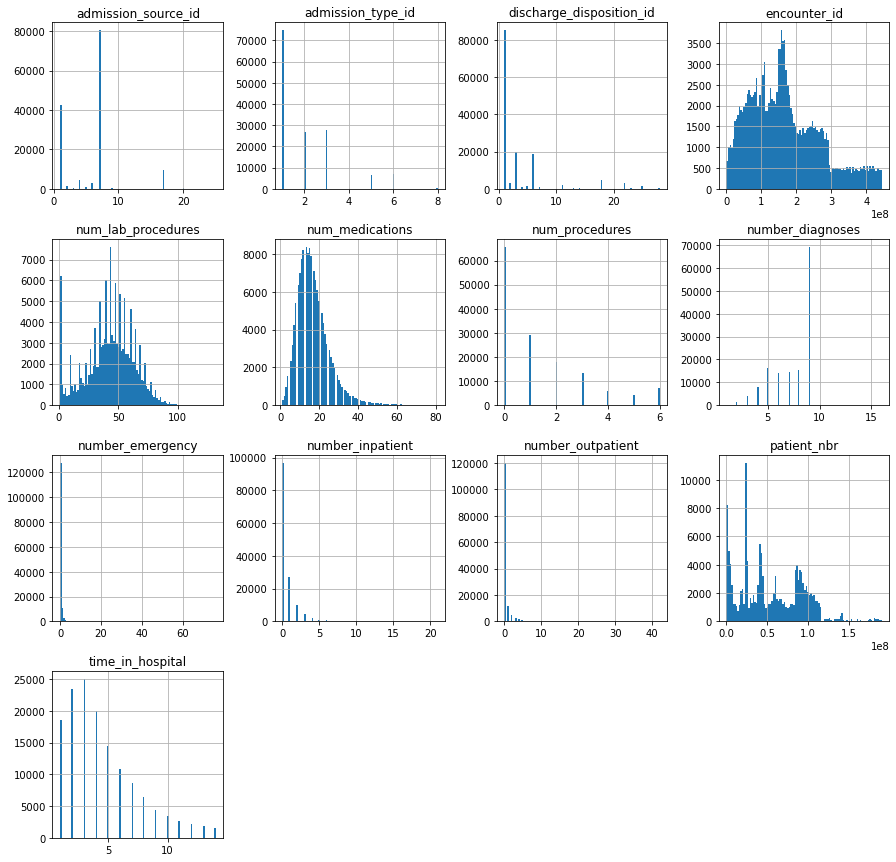

In [10]:
df.hist(figsize=(15,15), bins=100)
plt.show()

###### Based off the frequency histogram, numerical fields which numerical field(s) having a Gaussian(normal) distribution shape:
* num_medications

* num_lab_procedures

* time_in_hospital
        

In [11]:
# categorical columns
cat_col = list(df.select_dtypes(['object']).columns)
cat_col.extend(['admission_type_id','discharge_disposition_id', 'admission_source_id'])

In [12]:
cat_df = df[cat_col]
cat_df.nunique().sort_values(ascending=False)

other_diagnosis_codes       19374
primary_diagnosis_code        717
ndc_code                      251
medical_specialty              73
discharge_disposition_id       26
payer_code                     18
admission_source_id            17
weight                         10
age                            10
admission_type_id               8
race                            6
A1Cresult                       4
max_glu_serum                   4
readmitted                      3
gender                          3
change                          2
dtype: int64

###### Fields having high cardinality:
* other_diagnosis_codes:       19374
* primary_diagnosis_code:        716
* ndc_code:                      251

These fields have high cardniality because they are codes and as we have learnt in lessons the codes are created on the basis of diagnosis and medication.

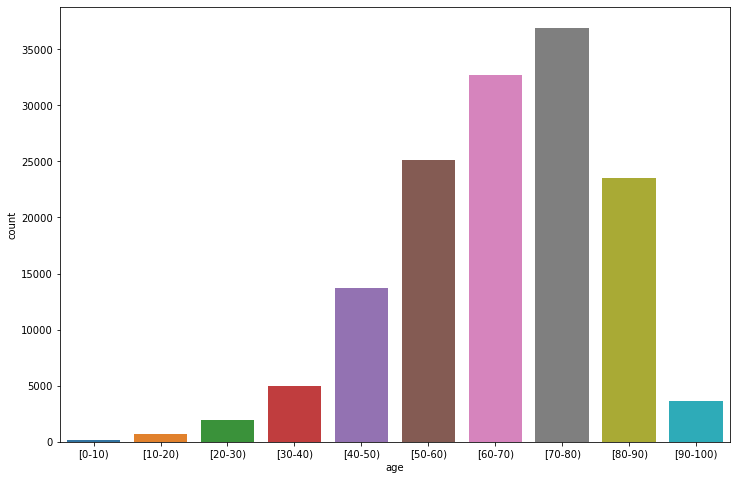

In [13]:
plt.figure(figsize=(12, 8))
sns.countplot(x='age', data=df);

In [14]:
df['age'].value_counts(normalize=True)

[70-80)     0.257474
[60-70)     0.228281
[50-60)     0.174971
[80-90)     0.164038
[40-50)     0.095723
[30-40)     0.034611
[90-100)    0.025233
[20-30)     0.013436
[10-20)     0.005111
[0-10)      0.001123
Name: age, dtype: float64

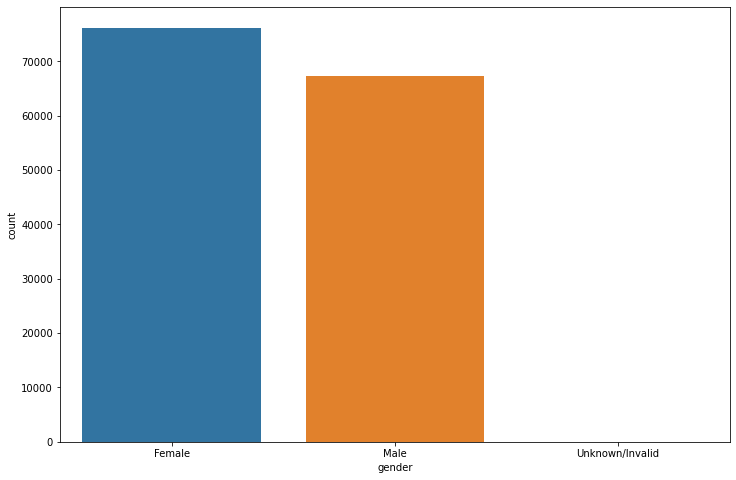

In [15]:
plt.figure(figsize=(12, 8))
sns.countplot(x='gender', data=df);

In [16]:
df['gender'].value_counts(normalize=True)

Female             0.531187
Male               0.468778
Unknown/Invalid    0.000035
Name: gender, dtype: float64

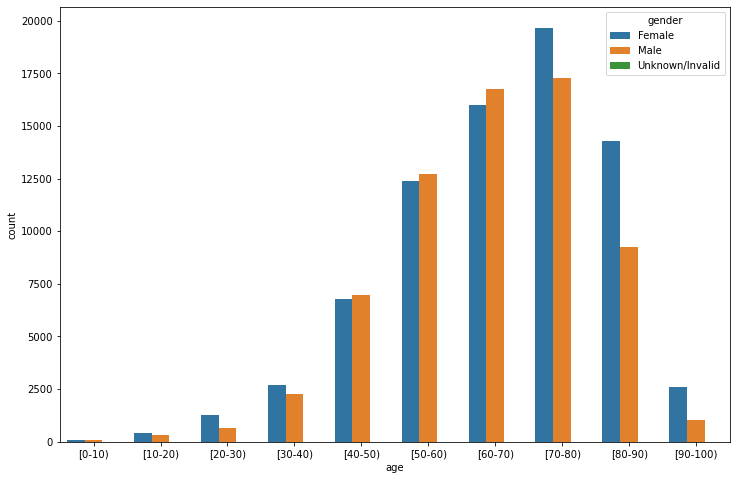

In [17]:
# distribution across both age and gender
plt.figure(figsize=(12, 8))
sns.countplot(x="age", hue="gender", data=df);

###### Demographic distributions
* Age: Most of the population is between the age group of 40-90. Maximum count is for 70-80.
* Gender:  We see more female population compared to male.

We also see more female population in the age group from 0-40 and 70-100. But, in the age group of 40-70, the male population is higher.

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [18]:
import tensorflow_data_validation as tfdv

Error importing tfx_bsl_extension.arrow.array_util. Some tfx_bsl functionalities are not availableError importing tfx_bsl_extension.arrow.table_util. Some tfx_bsl functionalities are not availableError importing tfx_bsl_extension.arrow.table_util. Some tfx_bsl functionalities are not available

In [19]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)
# error

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [20]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [21]:
ndc_code_df.sample(3)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
74,33342-240,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Macleods Pharmaceuticals Limited,Human Prescription Drug
112,65862-670,Repaglinide,Repaglinide,Tablet,Oral,Aurobindo Pharma Limited,Human Prescription Drug


In [22]:
ndc_code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NDC_Code              269 non-null    object
 1   Proprietary Name      269 non-null    object
 2   Non-proprietary Name  269 non-null    object
 3   Dosage Form           267 non-null    object
 4   Route Name            264 non-null    object
 5   Company Name          267 non-null    object
 6   Product Type          267 non-null    object
dtypes: object(7)
memory usage: 14.8+ KB


In [23]:
ndc_code_df.describe()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
count,269,269,269,267,264,267,267
unique,267,39,24,9,2,68,1
top,0781-5634,Metformin Hydrochloride,Metformin Hydrochloride,Tablet,Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
freq,2,61,71,159,263,17,267


In [24]:
from student_utils import reduce_dimension_ndc
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df) 

In [25]:
reduce_dim_df .sample(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
112965,247777548,85440699,Caucasian,Male,[80-90),?,2,1,1,2,MC,?,386,250|401,24,0,0,51,7,6,0,0378-1105,None,None,No,NO,0378-1105,Glipizide
109534,237863940,88410879,AfricanAmerican,Male,[70-80),?,1,1,7,2,MC,?,285,276|250,0,5,2,59,6,15,1,NaN,None,None,No,>30,NaN,NaN
15167,47475726,107240319,Caucasian,Female,[50-60),?,1,5,7,12,?,?,493,518|428,0,0,0,65,7,29,0,0173-0863,None,None,Ch,<30,0173-0863,Rosiglitazone Maleate


In [26]:
reduce_dim_df .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143482 entries, 0 to 143481
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143482 non-null  int64 
 1   patient_nbr               143482 non-null  int64 
 2   race                      143482 non-null  object
 3   gender                    143482 non-null  object
 4   age                       143482 non-null  object
 5   weight                    143482 non-null  object
 6   admission_type_id         143482 non-null  int64 
 7   discharge_disposition_id  143482 non-null  int64 
 8   admission_source_id       143482 non-null  int64 
 9   time_in_hospital          143482 non-null  int64 
 10  payer_code                143482 non-null  object
 11  medical_specialty         143482 non-null  object
 12  primary_diagnosis_code    143482 non-null  object
 13  other_diagnosis_codes     143482 non-null  object
 14  numb

In [27]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [28]:
#reduce_dim_df.drop(['ndc_code'],axis=1,inplace=True)

In [29]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [30]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


In [31]:
first_encounter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 12 to 143481
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      71518 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    71518 non-null  object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                71518 non-null  object
 11  medical_specialty         71518 non-null  object
 12  primary_diagnosis_code    71518 non-null  object
 13  other_diagnosis_codes     71518 non-null  object
 14  number_outpatient   

## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [32]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
grouping_field_list

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted',
 'NDC_Code']

In [33]:
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [34]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

In [35]:
agg_drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54271 entries, 0 to 54270
Data columns (total 48 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   encounter_id                                54271 non-null  int64 
 1   patient_nbr                                 54271 non-null  int64 
 2   race                                        54271 non-null  object
 3   gender                                      54271 non-null  object
 4   age                                         54271 non-null  object
 5   weight                                      54271 non-null  object
 6   admission_type_id                           54271 non-null  int64 
 7   discharge_disposition_id                    54271 non-null  int64 
 8   admission_source_id                         54271 non-null  int64 
 9   time_in_hospital                            54271 non-null  int64 
 10  payer_code            

In [36]:
agg_drug_df.sample(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
49519,314287904,140647496,?,Female,[70-80),?,1,1,7,3,?,InternalMedicine,424,518|414,0,0,0,29,9,8,2,0049-4110,None,None,No,NO,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29953,156137568,22692699,Caucasian,Male,[60-70),?,1,1,7,2,?,InternalMedicine,280,424|492,0,0,0,68,9,13,3,0904-6691,None,Norm,Ch,NO,0904-6691,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
33883,169803492,29916027,Caucasian,Female,[60-70),?,2,1,4,2,?,Cardiology,414,411|412,0,0,0,33,9,14,5,42291-582,None,None,Ch,NO,42291-582,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


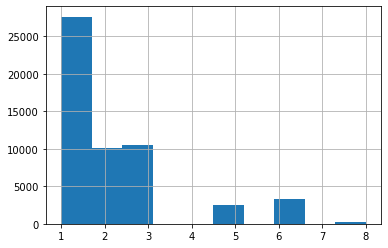

In [37]:
agg_drug_df['admission_type_id'].hist();

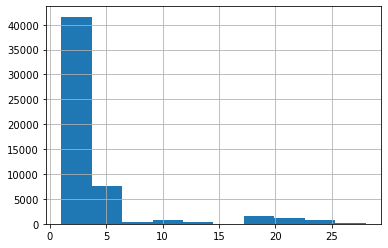

In [38]:
agg_drug_df['discharge_disposition_id'].hist();

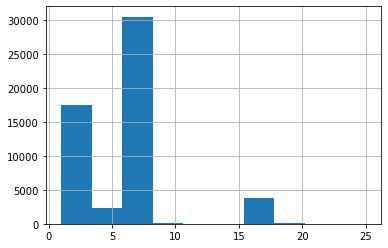

In [39]:
agg_drug_df['admission_source_id'].hist();

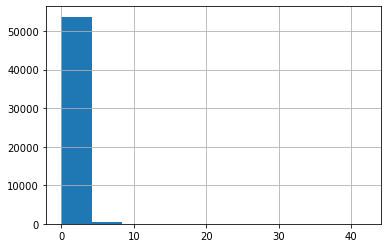

In [40]:
agg_drug_df['number_outpatient'].hist();

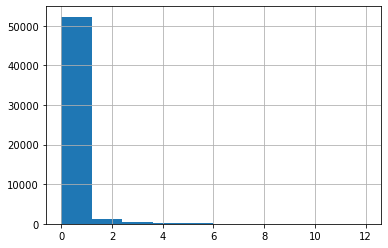

In [41]:
agg_drug_df['number_inpatient'].hist();

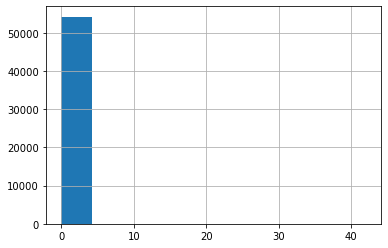

In [42]:
agg_drug_df['number_emergency'].hist();

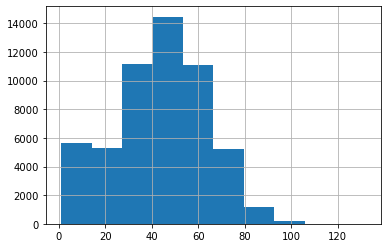

In [43]:
agg_drug_df['num_lab_procedures'].hist();

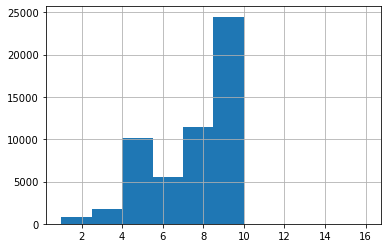

In [44]:
agg_drug_df['number_diagnoses'].hist();

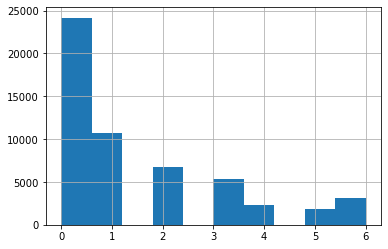

In [45]:
agg_drug_df['num_procedures'].hist();

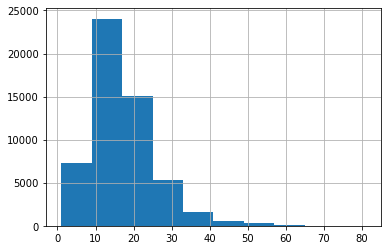

In [46]:
agg_drug_df['num_medications'].hist();

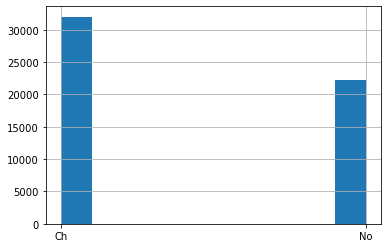

In [47]:
agg_drug_df['change'].hist();

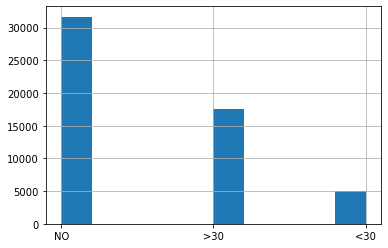

In [48]:
agg_drug_df['readmitted'].hist();

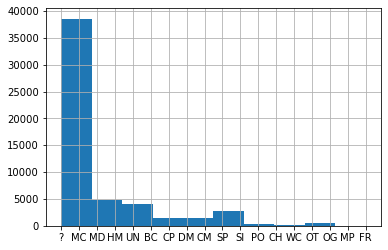

In [49]:
agg_drug_df['payer_code'].hist();

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: 

'encounter_id' - Not included

 'patient_nbr' - Not included
 
 'race', - Included as it's a demographic feature
 
 'gender'- Included as it's a demographic feature
 
 'age' - Included as it's a demographic feature
 
 'weight',- Not included as most data is not available
 
 'admission_type_id' - Not included due to non uniform distribution
 
 'discharge_disposition_id' - Not included due to non uniform distribution
 
 'admission_source_id' - Not included as this is just an ID and won't help in prediction.
 
 'time_in_hospital' - PREDICTOR_FIELD
 
 'payer_code' - Not included as most data is not available
 
 'medical_specialty'- Not included as most data is not available
 
 'primary_diagnosis_code' - Included as it can be an important source of info
 
 'other_diagnosis_codes'- Included due to high cardinality, this can also be an important source of info.
 
 'number_outpatient' - Not included due to non uniform distribution
 
 'number_inpatient' - Not included due to non uniform distribution
 
 'number_emergency' - Not included due to non uniform distribution
 
 'num_lab_procedures' - Included as it's a normal distribution
 
 'number_diagnoses' - Not included as it's not a normal distribution
 
 'num_medications'- Included as it's a normal distribution
 
 'num_procedures'- Not included due to non uniform distribution
 
 'ndc_code'- Not included as one hot encoding of generic drig name would be used 
 
 'max_glu_serum' - Not included as most data is not available
 
 'A1Cresult -  Not included as most data is not available
 
 'change' - Not included due to non uniform distribution
 
 'readmitted'- Not included due to non uniform distribution

In [50]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code", "other_diagnosis_codes"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ "num_lab_procedures", "num_medications"]
PREDICTOR_FIELD = 'time_in_hospital'

In [51]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [52]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [53]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [54]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54271 entries, 0 to 54270
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   patient_nbr                                 54271 non-null  int64  
 1   time_in_hospital                            54271 non-null  float64
 2   primary_diagnosis_code                      54271 non-null  object 
 3   other_diagnosis_codes                       54271 non-null  object 
 4   race                                        54271 non-null  object 
 5   gender                                      54271 non-null  object 
 6   age                                         54271 non-null  object 
 7   Acarbose                                    54271 non-null  object 
 8   Glimepiride                                 54271 non-null  object 
 9   Glipizide                                   54271 non-null  object 
 10  Glipizide_

In [55]:
processed_df.sample(3)

,patient_nbr,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
49363,87689466,11.0,491,577|438,Other,Female,[70-80),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,85,23
46413,33896214,6.0,410,428|426,Caucasian,Male,[60-70),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,66,19
5540,3108456,2.0,998,682|427,Caucasian,Male,[70-80),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,8


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [56]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [57]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [58]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     7318
2.0     9191
3.0     9740
4.0     7417
5.0     5348
6.0     3991
7.0     3123
8.0     2311
9.0     1597
10.0    1241
11.0    1008
12.0     783
13.0     663
14.0     540
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


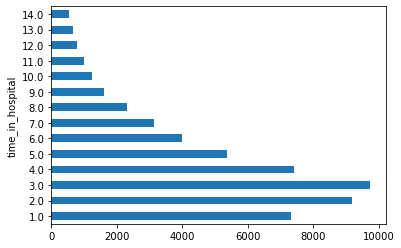

In [59]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4391
2.0     5514
3.0     5844
4.0     4450
5.0     3209
6.0     2394
7.0     1874
8.0     1386
9.0      958
10.0     745
11.0     605
12.0     470
13.0     398
14.0     324
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


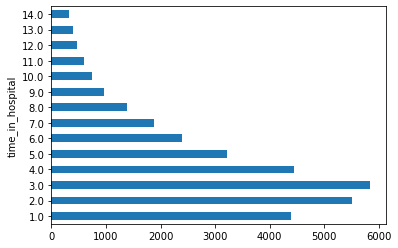

In [60]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1464
2.0     1839
3.0     1948
4.0     1484
5.0     1070
6.0      799
7.0      625
8.0      462
9.0      319
10.0     248
11.0     201
12.0     156
13.0     132
14.0     108
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


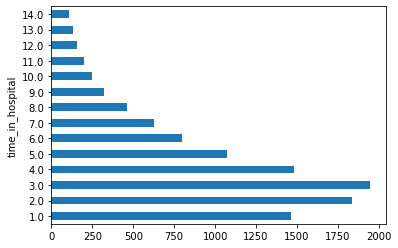

In [61]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             28572
Male               25697
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


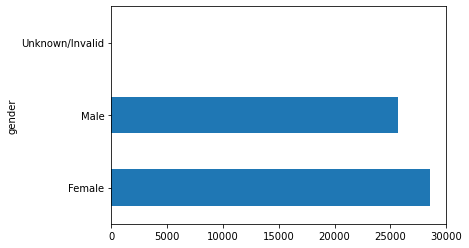

In [62]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             17141
Male               15420
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


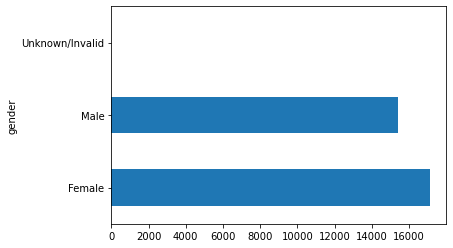

In [63]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5657
Male               5197
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


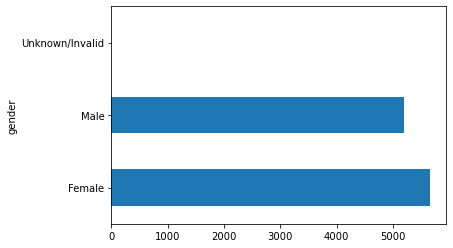

In [64]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [65]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [66]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [67]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [68]:
vocab_file_list 

['./diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/other_diagnosis_codes_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazone_vocab.txt',
 './diabetes_vocab/Pioglitazone_Hydrochl

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [69]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 620 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 9521 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Glimepiride is inferred from the nu

In [70]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=620, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 621), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [71]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [72]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [73]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [74]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=<function create_tf_numeric_feature.<locals>.<lambda> at 0x7fc984b79b90>)

tf.Tensor(
[[ 0.05]
 [-2.05]
 [-1.15]
 [-0.45]
 [-1.1 ]
 [-1.2 ]
 [ 0.25]
 [-1.05]
 [ 0.25]
 [-2.1 ]
 [-0.45]
 [-1.5 ]
 [ 1.15]
 [-0.15]
 [-0.35]
 [ 0.25]
 [-0.75]
 [ 0.95]
 [-0.15]
 [-2.1 ]
 [-2.  ]
 [ 1.35]
 [ 1.  ]
 [ 1.15]
 [ 1.9 ]
 [ 1.05]
 [-1.15]
 [-0.05]
 [-1.  ]
 [ 0.65]
 [ 0.3 ]
 [ 0.5 ]
 [-2.  ]
 [ 0.4 ]
 [ 0.3 ]
 [-0.35]
 [ 1.35]
 [ 2.45]
 [-0.25]
 [-1.8 ]
 [ 1.4 ]
 [ 0.1 ]
 [ 0.4 ]
 [-0.1 ]
 [-0.4 ]
 [-0.2 ]
 [ 0.3 ]
 [ 1.2 ]
 [-0.5 ]
 [-1.55]
 [-2.05]
 [ 0.65]
 [-0.15]
 [-2.1 ]
 [-2.1 ]
 [-0.4 ]
 [-0.65]
 [-2.1 ]
 [ 1.75]
 [-1.3 ]
 [ 0.85]
 [ 0.55]
 [ 0.45]
 [-1.15]
 [ 0.05]
 [ 0.45]
 [-0.8 ]
 [ 0.7 ]
 [-0.35]
 [-0.5 ]
 [-0.6 ]
 [ 0.05]
 [-0.05]
 [-0.95]
 [ 1.4 ]
 [-0.95]
 [ 0.95]
 [ 2.1 ]
 [-1.9 ]
 [ 0.85]
 [ 1.2 ]
 [ 0.25]
 [ 1.7 ]
 [ 0.25]
 [ 0.9 ]
 [ 2.95]
 [ 0.2 ]
 

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [75]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [76]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [100]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=20)

Train for 255 steps, validate for 85 steps
Epoch 1/20
255/255 [==============================] - 11s 42ms/step - loss: 27.1277 - mse: 26.9956 - val_loss: 22.9773 - val_mse: 22.5776
Epoch 2/20
255/255 [==============================] - 7s 27ms/step - loss: 18.4276 - mse: 17.9253 - val_loss: 16.4587 - val_mse: 15.8714
Epoch 3/20
255/255 [==============================] - 7s 27ms/step - loss: 14.9585 - mse: 14.2372 - val_loss: 13.3017 - val_mse: 12.2619
Epoch 4/20
255/255 [==============================] - 7s 27ms/step - loss: 13.0756 - mse: 12.0728 - val_loss: 11.7649 - val_mse: 10.7631
Epoch 5/20
255/255 [==============================] - 7s 27ms/step - loss: 11.1846 - mse: 10.2120 - val_loss: 11.7012 - val_mse: 10.9290
Epoch 6/20
255/255 [==============================] - 7s 27ms/step - loss: 10.9489 - mse: 9.9876 - val_loss: 11.3007 - val_mse: 10.4138
Epoch 7/20
255/255 [==============================] - 7s 27ms/step - loss: 10.3741 - mse: 9.5609 - val_loss: 10.7276 - val_mse: 10.0080

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [101]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [102]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [103]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [104]:
prob_output_df.head(10)

,pred,actual_value,pred_mean,pred_std
0,3.766584,4.0,3.483924,0.705145
1,2.559912,7.0,2.011089,0.701656
2,1.821358,1.0,1.985697,0.701915
3,2.163191,2.0,0.977676,0.699046
4,0.290602,4.0,3.509597,0.705644
5,2.731147,3.0,1.739931,0.701179
6,6.210558,5.0,3.558099,0.705793
7,2.236266,8.0,3.628299,0.705799
8,4.676685,8.0,5.149004,0.709907
9,1.919906,1.0,0.843739,0.698064


In [105]:
prob_output_df.describe()

,pred,actual_value,pred_mean,pred_std
count,10855.000000,10855.000000,10855.000000,10855.000000
mean,3.413698,4.403409,2.869774,0.703961
std,2.038998,2.977473,1.531633,0.003966
min,-1.288182,1.000000,0.626966,0.697980
25%,1.998565,2.000000,1.724576,0.701014
50%,3.095613,4.000000,2.558466,0.703121
75%,4.478135,6.000000,3.668598,0.705970
max,15.272339,14.000000,10.557482,0.724798


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [106]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [107]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [108]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
24040,78073299,Female,AfricanAmerican,4.0,0,0
6671,19535517,Female,Caucasian,7.0,0,1
27852,25201449,Female,AfricanAmerican,1.0,0,0
36707,1371933,Female,Caucasian,2.0,0,0
26296,2048985,Female,Caucasian,4.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [109]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve

In [110]:
# AUC, F1, precision and recall
# Summary
true = pred_test_df['label_value'].values 
pred = pred_test_df['score'].values
print('accuracy_score:', accuracy_score(true, pred))
print('f1_score:', f1_score(true, pred))
print('roc_auc_score:', roc_auc_score(true, pred))
print('classification_report:')
print(classification_report(true, pred))

accuracy_score: 0.7013357899585444
f1_score: 0.38247619047619047
roc_auc_score: 0.6124905399269142
classification_report:
              precision    recall  f1-score   support

           0       0.68      0.98      0.80      6735
           1       0.89      0.24      0.38      4120

    accuracy                           0.70     10855
   macro avg       0.78      0.61      0.59     10855
weighted avg       0.76      0.70      0.64     10855



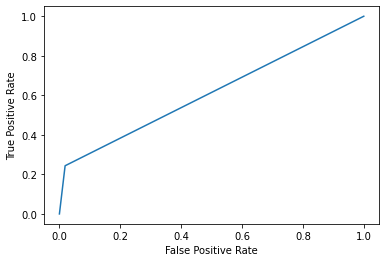

In [111]:
roc = roc_curve(true, pred)
plt.plot(roc[0], roc[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

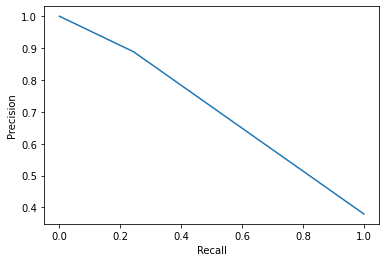

In [112]:
precision, recall, thresholds = precision_recall_curve(true, pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Precision-recall trade-off: 

Precision is defined as True positives divided by total predicted positives. 
Recall is defined as True positives divided by the total positives in the dataset.

By precision-recall tradeoff, we mean that by increasing one, the other will decrease. If the model perfectly separates the data, the value of precisiona and recall would be 1. In our case, we have a weighted average precision of 0.76 and recall of 0.70 which is decent. But there would be some false positives and false negatives. We will have less false positives if increase the precision and less false negatives if we increase the recall.  

Improvements:

The results can be improved by having more data and training on a bigger or a different model. We can also tune the hyperparameters(learning rate, number of epochs, ) and try different optimizers to get a better result.   

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [113]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [1130]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [114]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [115]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

In [116]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,1130,race,?,32,278,2,89,189,30,119,191,310,10855
1,1,binary 0/1,1130,race,AfricanAmerican,204,1691,19,550,1141,185,735,1160,1895,10855
2,1,binary 0/1,1130,race,Asian,6,75,2,21,54,4,25,56,81,10855
3,1,binary 0/1,1130,race,Caucasian,843,7289,98,2343,4946,745,3088,5044,8132,10855
4,1,binary 0/1,1130,race,Hispanic,22,216,4,60,156,18,78,160,238,10855
5,1,binary 0/1,1130,race,Other,23,176,1,53,123,22,75,124,199,10855
6,1,binary 0/1,1130,gender,Female,586,5071,68,1667,3404,518,2185,3472,5657,10855
7,1,binary 0/1,1130,gender,Male,544,4653,58,1448,3205,486,1934,3263,5197,10855
8,1,binary 0/1,1130,gender,Unknown/Invalid,0,1,0,1,0,0,1,0,1,10855


In [117]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,?,0.25,0.99,0.32,0.06,0.01,0.75,0.68,0.94,0.03,0.10,0.38
1,race,AfricanAmerican,0.25,0.98,0.33,0.09,0.02,0.75,0.67,0.91,0.18,0.11,0.39
2,race,Asian,0.16,0.96,0.28,0.33,0.04,0.84,0.72,0.67,0.01,0.07,0.31
3,race,Caucasian,0.24,0.98,0.32,0.12,0.02,0.76,0.68,0.88,0.75,0.10,0.38
4,race,Hispanic,0.23,0.98,0.28,0.18,0.02,0.77,0.72,0.82,0.02,0.09,0.33
5,race,Other,0.29,0.99,0.30,0.04,0.01,0.71,0.70,0.96,0.02,0.12,0.38
6,gender,Female,0.24,0.98,0.33,0.12,0.02,0.76,0.67,0.88,0.52,0.10,0.39
7,gender,Male,0.25,0.98,0.31,0.11,0.02,0.75,0.69,0.89,0.48,0.10,0.37
8,gender,Unknown/Invalid,0.00,NaN,1.00,NaN,NaN,1.00,0.00,NaN,0.00,0.00,1.00


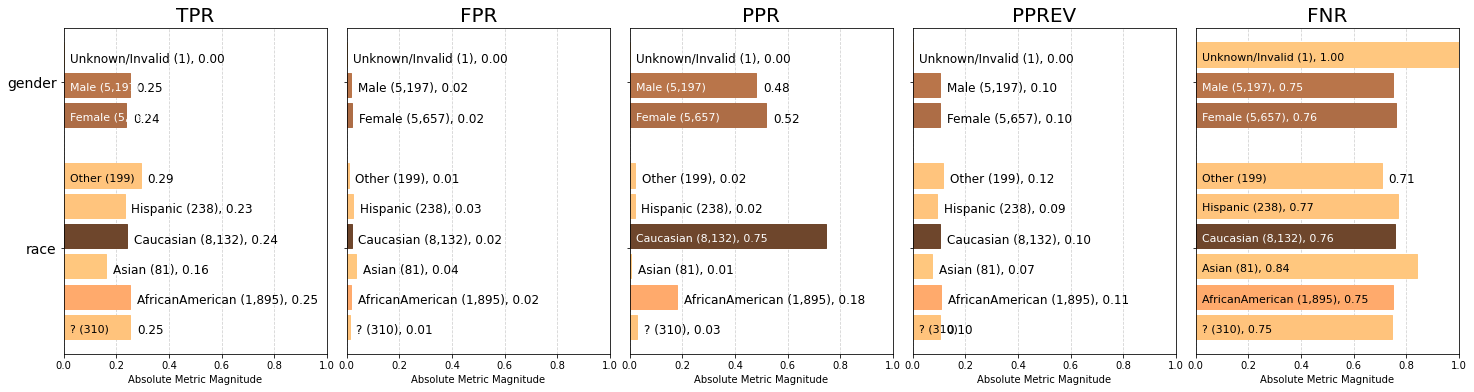

In [118]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

In terms of gender, there doesn't seem to be any bias. But in terms of race, we see a much higher PPR for Caucasian compared to any other group. Since the precision is high for Caucasions, it would have less false positives. This would also mean that as per this modeel, Caucasians would meet the predictions more often than other groups. 

## Fairness Analysis Example - Relative to a Reference Group 

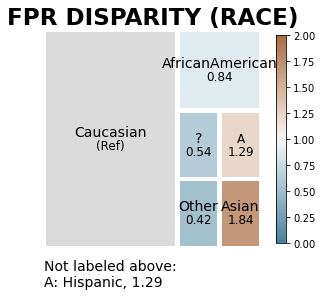

In [119]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

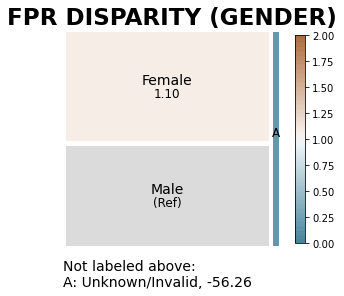

In [120]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

We see that Asian and Hispanic groups have a higher fpr disparity compared to Caucasians. This can be due due to low number of samples. With more data, there could be better result
We do not see a signigicant fpr disparity in terms of gender.